In [1]:
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from sklearn.svm import SVC
from sklearn import svm, metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import rbf_kernel

print("Installed tensorflow version: ", tf.__version__)

Installed tensorflow version:  2.4.0-rc0


# Load dataset

In [2]:
print("[Info.] where am I?")
%pwd

[Info.] where am I?


'/Users/kimgeon/work/etri'

In [3]:
#Normal dataset
nonleak_data = np.load('./data/nonleak_data.npy')

#Leak dataset
leak_data = np.load('./data/leak_data.npy')

print(leak_data.shape, nonleak_data.shape)

(9225, 320) (9924, 320)


In [4]:
##### Labeling
nonleak_label = np.zeros(leak_data.shape[0])   # Normal data - label 0
leak_label = np.ones(nonleak_data.shape[0])  # Leak data - label 1

print('[Info.] Number of normal dataset: ', len(nonleak_label))
print('[Info.] Number of leak dataset: ', len(leak_label))

[Info.] Number of normal dataset:  9225
[Info.] Number of leak dataset:  9924


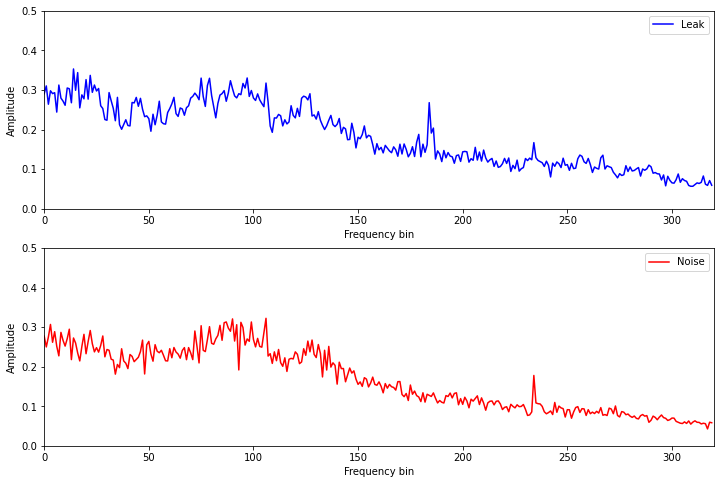

In [5]:
##### Display the measured signals
kk = 100

plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(leak_data[kk,:], color='blue')
plt.xlabel('Frequency bin')
plt.ylabel('Amplitude')
plt.legend(['Leak'])
plt.axis([0, 320, 0, 0.5])

plt.subplot(2,1,2)
plt.plot(nonleak_data[kk,:], color='red')
plt.xlabel('Frequency bin')
plt.ylabel('Amplitude')
plt.legend(['Noise'])
plt.axis([0, 320, 0, 0.5])

plt.show()

# Data shuffle

In [6]:
Train_raw = np.concatenate((nonleak_data, leak_data), axis=0)
Train_label = np.concatenate((nonleak_label, leak_label))
print(Train_raw.shape, Train_label.shape)
print(Train_label[9000:9100], Train_label[10000:10100])

(19149, 320) (19149,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [7]:
Train_label.shape

(19149,)

In [8]:
Train_label

array([0., 0., 0., ..., 1., 1., 1.])

In [9]:
len(Train_label[Train_label == 0])

9225

In [10]:
len(Train_label[Train_label == 1])

9924

In [11]:
# s라는 배열에 data의 인덱스를 넣고 섞은 뒤 data와 data_label 배열에 대입.(train)
s = np.arange(Train_raw.shape[0])
np.random.shuffle(s)

data_tr = Train_raw[s]
data_tr_label = Train_label[s]
print(data_tr_label[0:100])

[0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1.]


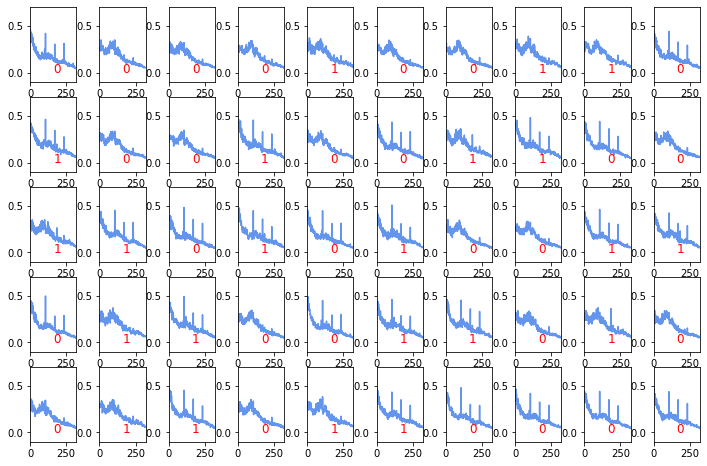

In [12]:
# Define signal plot function
def show_signal_subplot(n_show, data, label, YRNG_MIN=0, YRNG_MAX=0.5):
    plt.figure(2, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.5)
    for i in range(n_show):
        plt.subplot(5, 10, i + 1)
        plt.plot(data[i], color='cornflowerblue')
        plt.text(int(data.shape[1]/2), 0, "%d" % label[i], fontsize=12, color='r')
        plt.xlim(0, data.shape[1])
        plt.ylim(YRNG_MIN, YRNG_MAX)

show_signal_subplot(50, data_tr, data_tr_label, -0.1, 0.7)

# Data Splitting - Training / test datasets

In [51]:
SPL_RATIO = 0.9 
index = round(data_tr.shape[0]*SPL_RATIO)
# train 데이터와 test 데이터로 분리
train_X, train_Y = data_tr[:index], data_tr_label[:index]
test_X, test_Y = data_tr[index:], data_tr_label[index:]

print('[Info.] Number of training dataset: ', len(train_X))
print('[Info.] Number of test dataset: ', len(test_X))

train_labels = to_categorical(train_Y)
test_labels = to_categorical(test_Y)

[Info.] Number of training dataset:  17234
[Info.] Number of test dataset:  1915


# Implement SVM

In [80]:
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((17234, 320), (1915, 320), (17234,), (1915,))

In [74]:
start = timeit.default_timer()

svc=SVC(kernel='linear', C = 100)
svc.fit(train_X, train_Y)

stop = timeit.default_timer()
print(stop - start)

8.469110083000032


In [75]:
y_pred = svc.predict(test_X)
metrics.confusion_matrix(test_Y, y_pred)

array([[910,   0],
       [ 58, 947]])

In [76]:
print('Accuracy Score:')
print(metrics.accuracy_score(test_Y, y_pred))
print('Recall Score:')
print(metrics.recall_score(test_Y, y_pred))
print('Precision Score:')
print(metrics.precision_score(test_Y, y_pred))

Accuracy Score:
0.9697127937336815
Recall Score:
0.9422885572139303
Precision Score:
1.0


# Weight

In [77]:
svc_weight=SVC(kernel='linear', C = 100, class_weight='balanced')
svc_weight.fit(train_X, train_Y)

SVC(C=100, class_weight='balanced', kernel='linear')

In [78]:
y_pred_weight = svc_weight.predict(test_X)
metrics.confusion_matrix(test_Y, y_pred_weight)

array([[910,   0],
       [ 58, 947]])

In [79]:
print('Accuracy Score:')
print(metrics.accuracy_score(test_Y, y_pred_weight))
print('Recall Score:')
print(metrics.recall_score(test_Y, y_pred_weight))
print('Precision Score:')
print(metrics.precision_score(test_Y, y_pred_weight))

Accuracy Score:
0.9697127937336815
Recall Score:
0.9422885572139303
Precision Score:
1.0


# Grid Search

In [81]:
values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = [{'kernel':['rbf'], 'C':values, 'gamma':values},
               {'kernel':['linear'], 'C':values}]
gs = GridSearchCV(SVC(), param_grid, cv= KFold(n_splits=5), scoring='accuracy', verbose = 3)
gs.fit(train_X, train_Y)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.510 total time=  47.9s
[CV 2/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.521 total time=  47.0s
[CV 3/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.518 total time=  46.5s
[CV 4/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.527 total time=  47.3s
[CV 5/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.512 total time=  46.5s
[CV 1/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.510 total time=  49.2s
[CV 2/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.521 total time=  49.4s
[CV 3/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.518 total time=  48.6s
[CV 4/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.527 total time=  48.5s
[CV 5/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.512 total time=  49.2s
[CV 1/5] END ....C=0.001, gamma=0.1, kernel=rbf;, score=0.510 total time=  49.5s
[CV 2/5] END ....C=0.001, gamma=0.1, kernel=rbf

[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.960 total time=   6.7s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.963 total time=   6.9s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.960 total time=   6.8s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.967 total time=   6.5s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.963 total time=   5.3s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.960 total time=   5.2s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.963 total time=   5.3s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.960 total time=   5.2s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.967 total time=   5.4s
[CV 1/5] END .........C=1, gamma=10, kernel=rbf;, score=0.962 total time=  10.5s
[CV 2/5] END .........C=1, gamma=10, kernel=rbf;, score=0.960 total time=  10.5s
[CV 3/5] END .........C=1, gamma=10, kernel=rbf;, score=0.963 total time=  10.6s
[CV 4/5] END .........C=1, g

[CV 4/5] END ...............C=10, kernel=linear;, score=0.960 total time=   4.1s
[CV 5/5] END ...............C=10, kernel=linear;, score=0.967 total time=   4.3s
[CV 1/5] END ..............C=100, kernel=linear;, score=0.962 total time=   5.8s
[CV 2/5] END ..............C=100, kernel=linear;, score=0.960 total time=   5.6s
[CV 3/5] END ..............C=100, kernel=linear;, score=0.963 total time=   5.9s
[CV 4/5] END ..............C=100, kernel=linear;, score=0.961 total time=   5.7s
[CV 5/5] END ..............C=100, kernel=linear;, score=0.967 total time=   5.8s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['linear']}],
             scoring='accuracy', verbose=3)

## Grid Search 결과 최적의 파라미터로 튜닝해 모델 학습

In [83]:
print('optimal parameter ==> {}'.format(gs.best_params_))
print('optimal parameter의 점수 ==> {:.3f}'.format(gs.best_score_))
print('optimal parameter로 일반화 점수 ==> {:.3f}'.format(gs.score(test_X, test_Y)))

optimal parameter ==> {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
optimal parameter의 점수 ==> 0.963
optimal parameter로 일반화 점수 ==> 0.970


In [84]:
# 모델 중 Recall Score가 가장 높으면서 다른 Score가 가장 높은 모델 svc_optimal
svc_optimal=SVC(kernel='rbf', C = 1, gamma = 1)
svc_optimal.fit(train_X, train_Y)

SVC(C=1, gamma=1)

In [85]:
y_pred_optimal = svc_optimal.predict(test_X)
metrics.confusion_matrix(test_Y, y_pred_optimal)

array([[910,   0],
       [ 58, 947]])

In [86]:
print('Accuracy Score:')
print(metrics.accuracy_score(test_Y, y_pred_optimal))
print('Recall Score:')
print(metrics.recall_score(test_Y, y_pred_optimal))
print('Precision Score:')
print(metrics.precision_score(test_Y, y_pred_optimal))

Accuracy Score:
0.9697127937336815
Recall Score:
0.9422885572139303
Precision Score:
1.0


# Model Save

In [ ]:
##### Save trained model
model_dir = "./save_model"
if os.path.exists(model_dir):
    pass
else:
    os.mkdir(model_dir)
    
model_path = os.path.join(model_dir, 'svm_leak_model_1.h5')    
model.save(model_path)